In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from vector import array as vec_array

# Physical constants
M_PROTON = 0.938  # GeV
M_PION0  = 0.13498  # GeV

# Optional: Style
plt.style.use("seaborn-v0_8-poster")

# Load skimmed data file
file_path = "/home/ubuntu/nps_analysis/pi0_analysis/data/nps_hms_coin_skimmed_4398.root"
tree = uproot.open(file_path)["T"]

# Load branches
branches = tree.arrays([
    "T.hms.hEDTM_tdcTimeRaw", "T.hms.hTRIG4_tdcTimeRaw", "H.cal.etot", "H.cal.etotnorm",
    "H.cal.etottracknorm", "H.cal.etrack", "H.cal.etracknorm",
    "H.cer.npeSum", "H.gtr.dp", "H.gtr.th", "H.gtr.ph", "H.gtr.y", "H.gtr.p", 
    "H.gtr.px", "H.gtr.py", "H.gtr.pz", "H.gtr.x", "H.gtr.y", "NPS.cal.nclust", "NPS.cal.clusE",
    "NPS.cal.clusX", "NPS.cal.clusY", "NPS.cal.clusT"
])

tree.keys()

['Ndata.NPS.cal.clusE',
 'NPS.cal.clusE',
 'Ndata.NPS.cal.clusT',
 'NPS.cal.clusT',
 'Ndata.NPS.cal.clusX',
 'NPS.cal.clusX',
 'Ndata.NPS.cal.clusY',
 'NPS.cal.clusY',
 'H.cal.etot',
 'H.cal.etotnorm',
 'H.cal.etottracknorm',
 'H.cal.etrack',
 'H.cal.etracknorm',
 'H.cer.npeSum',
 'H.gtr.dp',
 'H.gtr.p',
 'H.gtr.ph',
 'H.gtr.px',
 'H.gtr.py',
 'H.gtr.pz',
 'H.gtr.th',
 'H.gtr.x',
 'H.gtr.y',
 'NPS.cal.nclust',
 'T.hms.hEDTM_tdcTimeRaw',
 'T.hms.hTRIG1_tdcTimeRaw',
 'T.hms.hTRIG2_tdcTimeRaw',
 'T.hms.hTRIG3_tdcTimeRaw',
 'T.hms.hTRIG4_tdcTimeRaw',
 'T.hms.hTRIG5_tdcTimeRaw',
 'T.hms.hTRIG6_tdcTimeRaw']

In [6]:
import numba as nb
import numpy as np

# --- Constants ---
m_e = 0.000511
m_p = 0.938
E_beam = 10.537  # GeV
z_nps = 407.0    # cm
M_PION0 = 0.13498  # GeV (π0 mass)

# Incoming 4-vectors in lab frame
p4_ein = np.array([E_beam, 0.0, 0.0, E_beam])
p4_pin = np.array([m_p, 0.0, 0.0, 0.0])

# Example HMS cut function ;
@nb.njit
def pass_hms_cuts(edt, dp, etrnorm, npe, th, ph):
    # Apply your real cut conditions here
    return (edt < 0.1 and abs(dp) <= 8.5 and abs(etrnorm - 1) < 0.1 and npe > 1.0 and
            abs(th) <= 0.09 and abs(ph) <= 0.09)

# Cluster quality function
@nb.njit
def is_good_cluster(e, t, x, y):
    return ( 147 <= t <= 153 and
            -29.16 < x < 29.16 and -35.64 < y < 35.64)

@nb.njit
def invariant_missing_mass_correction_fac_mazouz(miss_mass_sq_pr, Ee, px_e, py_e, pz_e, e1, e2, p4_pi0):
    # Virtual photon momentum vector
    q_vec_temp = np.array([-px_e, -py_e, E_beam - pz_e])  # k - k'

    q_mag = np.sqrt(q_vec_temp[0]**2 + q_vec_temp[1]**2 + q_vec_temp[2]**2)

    # Unit vectors for theta_{pi,gamma*}
    norm1 = q_mag
    norm2 = np.sqrt(p4_pi0[1]**2 + p4_pi0[2]**2 + p4_pi0[3]**2)
    u1x, u1y, u1z = q_vec_temp / norm1
    u2x, u2y, u2z = p4_pi0[1:4] / norm2
    dot = u1x*u2x + u1y*u2y + u1z*u2z
    dot = min(1.0, max(-1.0, dot))
    theta = np.arccos(dot)

    # Invariant mass of pi0
    m_inv_sq = p4_pi0[0]**2 - (p4_pi0[1]**2 + p4_pi0[2]**2 + p4_pi0[3]**2)
    m_inv = np.sqrt(m_inv_sq) if m_inv_sq > 0 else 0.0

    # nu = energy transfer
    nu = E_beam - Ee

    # Correction factor (Eq. 7)
    corr_fac = (2.0/m_inv) * (
        m_inv**2 - 2.0*np.sqrt(2.0) * (nu + M_PROTON - q_mag*np.cos(theta)) * ((e1*e2)/(e1 + e2))
    )

    # # Apply correction: Mx^2 -> Mx^2 - corr*(m_inv - m_pi)
    # miss_mass_sq_temp = miss_mass_sq_pr - corr_fac*(m_inv - M_PION0)

    # return np.sqrt(miss_mass_sq_temp) if miss_mass_sq_temp > 0.0 else 0.0
    return corr_fac


@nb.njit
def invariant_missing_mass_correction_fac_avnish(miss_mass_sq_pr, Ee, px_e, py_e, pz_e, e1, e2, p4_pi0):
    # Virtual photon momentum vector
    q_vec_temp = np.array([-px_e, -py_e, E_beam - pz_e])  # k - k'

    q_mag = np.sqrt(q_vec_temp[0]**2 + q_vec_temp[1]**2 + q_vec_temp[2]**2)
    pi0_mag = np.sqrt(p4_pi0[1]**2 + p4_pi0[2]**2 + p4_pi0[3]**2)

    # Unit vectors for theta_{pi,gamma*}
    norm1 = q_mag
    norm2 = np.sqrt(p4_pi0[1]**2 + p4_pi0[2]**2 + p4_pi0[3]**2)
    u1x, u1y, u1z = q_vec_temp / norm1
    u2x, u2y, u2z = p4_pi0[1:4] / norm2
    dot = u1x*u2x + u1y*u2y + u1z*u2z
    dot = min(1.0, max(-1.0, dot))
    theta = np.arccos(dot)

    # Invariant mass of pi0
    m_inv_sq = p4_pi0[0]**2 - (p4_pi0[1]**2 + p4_pi0[2]**2 + p4_pi0[3]**2)
    m_inv = np.sqrt(m_inv_sq) if m_inv_sq > 0 else 0.0

    # nu = energy transfer
    nu = E_beam - Ee

    # Correction factor (Eq. 7)
    corr_fac = (2.0/m_inv) * (
        m_inv**2 - (e1 + e2)*(nu + M_PROTON - q_mag*np.cos(theta)*pi0_mag/(e1 + e2))
    )

    # Apply correction: Mx^2 -> Mx^2 - corr*(m_inv - m_pi)
    miss_mass_sq_temp = miss_mass_sq_pr - corr_fac*(m_inv - M_PION0)

    return np.sqrt(miss_mass_sq_temp) if miss_mass_sq_temp > 0.0 else 0.0


@nb.njit(parallel=True)
def reconstruct_pi0_pr(Ee, px_e, py_e, pz_e, e1, e2, t1, t2, x1, y1, x2, y2,
                              edt, dp, etrnorm, npe, th, ph,
                              z_nps=407.0, theta_deg=-17.51, theta_tol=0.02):
    """
    Computes pi0 mass for arrays of photon energies and positions,
    returning mass, theta_data, and theta_ideal for each event.
    
    Parameters
    ----------
    e1, e2 : float arrays
        Energies of the two photons [GeV]
    x1, y1, x2, y2 : float arrays
        Cluster positions in NPS plane [cm]
    z_nps : float
        Distance to NPS [cm]
    
    Returns
    -------
    masses, theta_data, theta_ideal : float arrays
    """
    """
    Compute missing proton mass and apply opening angle selection in Numba.
    Returns:
        masses_pr_all_arr: All missing masses
        masses_pr_w_opening_angle: Missing masses passing π0 opening-angle cut
    """



    n = len(Ee)
    counter = 0
    invariant_pi0_all_arr = np.zeros(n)
    invariant_pi0_cut_arr = np.zeros(n)

    miss_pr_all_arr = np.zeros(n)
    miss_pr_cut_arr = np.zeros(n)
    miss_pr_corr_mazouz_arr = np.zeros(n)
    miss_pr_corr_avnish_arr = np.zeros(n)
    corr_fac_mazouz_arr = np.zeros(n)

    theta_data_arr = np.zeros(n)
    theta_ideal_arr = np.zeros(n)

    # Precompute rotation parameters (NPS to Hall)
    theta = np.deg2rad(theta_deg)
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)

    for i in nb.prange(n):

        # detectors cuts applied 
        if Ee[i] < 3.5:
            continue

        if not pass_hms_cuts(edt[i], dp[i], etrnorm[i], npe[i], th[i], ph[i]):
            continue

        if not (is_good_cluster(e1[i], t1[i], x1[i], y1[i]) and
                is_good_cluster(e2[i], t2[i], x2[i], y2[i])):
            continue

        # --- Electron 4-vector ---
        p4_eout = np.zeros(4)
        p4_eout[0] = Ee[i]
        p4_eout[1] = px_e[i]
        p4_eout[2] = py_e[i]
        p4_eout[3] = pz_e[i]

        # --- Norms ---
        norm1 = np.sqrt(x1[i]**2 + y1[i]**2 + z_nps**2)
        norm2 = np.sqrt(x2[i]**2 + y2[i]**2 + z_nps**2)

        # --- Unit vectors ---
        u1x, u1y, u1z = x1[i]/norm1, y1[i]/norm1, z_nps/norm1
        u2x, u2y, u2z = x2[i]/norm2, y2[i]/norm2, z_nps/norm2

        # Photon momenta
        ph1x, ph1y, ph1z = e1[i]*u1x, e1[i]*u1y, e1[i]*u1z
        ph2x, ph2y, ph2z = e2[i]*u2x, e2[i]*u2y, e2[i]*u2z

        # --- Rotate photons to Hall frame (rotation about Y-axis) ---
        # NPS to the left => negative angle
        # x' = cosθ*x - sinθ*z
        # y' = y
        # z' = sinθ*x + cosθ*z

        p1x = cos_t*ph1x - sin_t*ph1z
        p1y = ph1y
        p1z = sin_t*ph1x + cos_t*ph1z

        p2x = cos_t*ph2x - sin_t*ph2z
        p2y = ph2y
        p2z = sin_t*ph2x + cos_t*ph2z

        # --- π⁰ 4-vector ---
        p4_pi0 = np.zeros(4)
        p4_pi0[0] = e1[i] + e2[i]
        p4_pi0[1] = p1x + p2x
        p4_pi0[2] = p1y + p2y
        p4_pi0[3] = p1z + p2z

        # --- Final-state and missing 4-vector ---
        p4_out = p4_eout + p4_pi0
        p4_miss = (p4_ein + p4_pin) - p4_out

        # Invariant mass squared of pi0 4-vector
        invariant_mass_sq_pi0 = p4_pi0[0]**2 - (p4_pi0[1]**2 + p4_pi0[2]**2 + p4_pi0[3]**2)
        invariant_pi0_all_arr[i] = np.sqrt(invariant_mass_sq_pi0) if invariant_mass_sq_pi0 > 0.0 else 0.0

        # Missing mass squared of missing proton 4-vector
        miss_mass_sq_pr = p4_miss[0]**2 - (p4_miss[1]**2 + p4_miss[2]**2 + p4_miss[3]**2)
        miss_pr_all_arr[i] = np.sqrt(miss_mass_sq_pr) if miss_mass_sq_pr > 0.0 else 0.0

        # --- Opening angles ---
        dot = u1x*u2x + u1y*u2y + u1z*u2z
        dot = min(1.0, max(-1.0, dot))  # Clamp for numerical stability
        theta_data = np.arccos(dot)
        # Ideal opening angle
        s = 4.0 * e1[i] * e2[i]
        arg = M_PION0 / np.sqrt(s) if s > 0 else 2.0  # force invalid if 0 energy
        if -1.0 <= arg <= 1.0:
            theta_ideal = 2.0 * np.arcsin(arg)
        else:
            theta_ideal = 0.0  # mark as invalid

        theta_data_arr[i] = theta_data
        theta_ideal_arr[i] = theta_ideal

        # --- Mass only if within tolerance ---
        theta_tolerance_rad = theta_tol
        if np.abs(theta_data - theta_ideal) < theta_tolerance_rad:
            counter = counter + 1
            miss_pr_cut_arr[i] = np.sqrt(miss_mass_sq_pr) if miss_mass_sq_pr > 0.0 else 0.0
            # miss_pr_corr_mazouz_arr_temp = invariant_missing_mass_correction_fac_mazouz(miss_mass_sq_pr, Ee[i], px_e[i], py_e[i], pz_e[i], e1[i], e2[i], p4_pi0) 
            # miss_pr_corr_mazouz_arr[i] = miss_pr_corr_mazouz_arr_temp if miss_pr_corr_mazouz_arr_temp > 0.0 else 0.0
            corr_fac_mazouz_temp = invariant_missing_mass_correction_fac_mazouz(miss_mass_sq_pr, Ee[i], px_e[i], py_e[i], pz_e[i], e1[i], e2[i], p4_pi0)
            corr_fac_mazouz_arr[i] = corr_fac_mazouz_temp
            miss_pr_corr_avnish_arr_temp = invariant_missing_mass_correction_fac_avnish(miss_mass_sq_pr, Ee[i], px_e[i], py_e[i], pz_e[i], e1[i], e2[i], p4_pi0) 
            miss_pr_corr_avnish_arr[i] = miss_pr_corr_avnish_arr_temp if miss_pr_corr_avnish_arr_temp > 0.0 else 0.0
            invariant_pi0_cut_arr[i] = np.sqrt(invariant_mass_sq_pi0) if invariant_mass_sq_pi0 > 0.0 else 0.0
        else:
            miss_pr_cut_arr[i] = 0.0  # or np.nan
            miss_pr_corr_mazouz_arr[i] = 0.0
            miss_pr_corr_avnish_arr[i] = 0.0
            invariant_pi0_cut_arr[i] = 0.0
            corr_fac_mazouz_arr[i] = 0.0

    avg_corr_fac_mazouz = np.sum(corr_fac_mazouz_arr)/counter
    print(avg_corr_fac_mazouz)
    miss_pr_corr_mazouz_arr = np.sqrt(miss_pr_cut_arr**2 - avg_corr_fac_mazouz*(invariant_pi0_cut_arr - M_PION0))
    miss_pr_corr_mazouz_arr = np.nan_to_num(miss_pr_corr_mazouz_arr, nan=0.0)
    return miss_pr_all_arr, miss_pr_cut_arr, miss_pr_corr_mazouz_arr, miss_pr_corr_avnish_arr, invariant_pi0_all_arr, invariant_pi0_cut_arr, theta_data_arr, theta_ideal_arr


In [7]:
import awkward as ak
import pandas as pd
import numpy as np

clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]
clusX = branches["NPS.cal.clusX"]
clusY = branches["NPS.cal.clusY"]

# --- Correct Mask ---
for energy_cut in np.arange(0.50, 2.8, 0.10):
    # energy_cut = 0.8
    mask_energy = clusE > energy_cut                     # per-cluster mask
    clusE_masked = clusE[mask_energy]
    clusT_masked = clusT[mask_energy]
    clusX_masked = clusX[mask_energy]
    clusY_masked = clusY[mask_energy]

    # --- Keep only events with >=2 clusters ---
    mask_2plus = ak.num(clusE_masked) >= 2
    clusE_sel = clusE_masked[mask_2plus]
    clusT_sel = clusT_masked[mask_2plus]
    clusX_sel = clusX_masked[mask_2plus]
    clusY_sel = clusY_masked[mask_2plus]

    # --- Select highest 2 clusters per event ---
    sort_idx = ak.argsort(clusE_sel, axis=1, ascending=False)
    top2_idx = sort_idx[:, :2]

    e_np = ak.to_numpy(clusE_sel[top2_idx])
    t_np = ak.to_numpy(clusT_sel[top2_idx])
    x_np = ak.to_numpy(clusX_sel[top2_idx])
    y_np = ak.to_numpy(clusY_sel[top2_idx])

    e1, e2 = e_np[:, 0], e_np[:, 1]
    t1, t2 = t_np[:, 0], t_np[:, 1]
    x1, x2 = x_np[:, 0], x_np[:, 1]
    y1, y2 = y_np[:, 0], y_np[:, 1]

    # 3. Apply combined mask to branches
    edt  = ak.to_numpy(branches["T.hms.hEDTM_tdcTimeRaw"][mask_2plus])
    dp   = ak.to_numpy(branches["H.gtr.dp"][mask_2plus])
    et   = ak.to_numpy(branches["H.gtr.p"][mask_2plus])
    etrnorm = ak.to_numpy(branches["H.cal.etracknorm"][mask_2plus])
    npe  = ak.to_numpy(branches["H.cer.npeSum"][mask_2plus])
    th   = ak.to_numpy(branches["H.gtr.th"][mask_2plus])
    ph   = ak.to_numpy(branches["H.gtr.ph"][mask_2plus])
    pe   = ak.to_numpy(branches["H.gtr.p"][mask_2plus])
    px_e = ak.to_numpy(branches["H.gtr.px"][mask_2plus])
    py_e = ak.to_numpy(branches["H.gtr.py"][mask_2plus])
    pz_e = ak.to_numpy(branches["H.gtr.pz"][mask_2plus])
    Ee   = ak.to_numpy(branches["H.gtr.p"][mask_2plus])  # momentum ~ energy


    # --- Reconstruct proton masses, π⁰ masses and angles ---
    miss_pr_all, miss_pr_cut, miss_pr_corr_mazouz, miss_pr_corr_avnish, invariant_pi0_all, invariant_pi0_cut, theta_data, theta_ideal\
        = reconstruct_pi0_pr(Ee, px_e, py_e, pz_e, e1, e2, t1, t2, x1, y1, x2, y2,
                                edt, dp, etrnorm, npe, th, ph,
                                z_nps=407.0, theta_deg=-17.51, theta_tol=0.02)

    # --- Save CSVs ---
    pd.DataFrame({
        "missing_mass_pr_all": miss_pr_all, 
        "missing_mass_pr_w_cuts": miss_pr_cut, 
        "missing_mass_pr_corrected_mazouz": miss_pr_corr_mazouz,
        "missing_mass_pr_corrected_avnish": miss_pr_corr_avnish,
        "invariant_mass_pi0_all": invariant_pi0_all,
        "invariant_mass_pi0_w_cuts": invariant_pi0_cut,
        "theta_data": theta_data, 
        "theta_ideal": theta_ideal}) \
        .to_csv(f"exclusive_pi0_proton_data_energycut_{energy_cut:.1f}.csv", index=False)

    print(f"Saved exclusive_pi0_proton_data_energycut_{energy_cut:.1f}.csv")

-14.936479021805049
Saved exclusive_pi0_proton_data_energycut_0.5.csv
-15.250685540063415
Saved exclusive_pi0_proton_data_energycut_0.6.csv
-15.666929414307667
Saved exclusive_pi0_proton_data_energycut_0.7.csv
-16.171990069803847
Saved exclusive_pi0_proton_data_energycut_0.8.csv
-16.771322167671126
Saved exclusive_pi0_proton_data_energycut_0.9.csv
-17.398540103712442
Saved exclusive_pi0_proton_data_energycut_1.0.csv
-18.077700442100234
Saved exclusive_pi0_proton_data_energycut_1.1.csv
-18.74789893072257
Saved exclusive_pi0_proton_data_energycut_1.2.csv
-19.43263426304624
Saved exclusive_pi0_proton_data_energycut_1.3.csv
-20.1106228858644
Saved exclusive_pi0_proton_data_energycut_1.4.csv
-20.76379957411325
Saved exclusive_pi0_proton_data_energycut_1.5.csv
-21.404350638589847
Saved exclusive_pi0_proton_data_energycut_1.6.csv
-21.98731882434187
Saved exclusive_pi0_proton_data_energycut_1.7.csv
-22.526041089810132
Saved exclusive_pi0_proton_data_energycut_1.8.csv
-23.099202719985758
Saved 

In [8]:
import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

df1 = pd.read_csv("exclusive_pi0_proton_data_energycut_0.6.csv")
# # df2 = pd.read_csv("proton_mass_data.csv")
# # df3 = pd.read_csv("pi0_mass_theta_data.csv")


df1[df1["invariant_mass_pi0_w_cuts"]>0]
# # df2[df2["mass_all"]>0]

,missing_mass_pr_all,missing_mass_pr_w_cuts,missing_mass_pr_corrected_mazouz,missing_mass_pr_corrected_avnish,invariant_mass_pi0_all,invariant_mass_pi0_w_cuts,theta_data,theta_ideal
29,1.609413,1.609413,1.587155,1.585226,0.130315,0.130315,0.102797,0.106480
82,1.079535,1.079535,1.111551,1.147585,0.139580,0.139580,0.064978,0.062836
115,1.575771,1.575771,1.533796,1.530026,0.126421,0.126421,0.094200,0.100582
116,1.004614,1.004614,1.008771,1.013445,0.135529,0.135529,0.059355,0.059115
120,1.818542,1.818542,1.767978,1.750753,0.123089,0.123089,0.092890,0.101871
...,...,...,...,...,...,...,...,...
640590,0.902833,0.902833,0.913985,0.932100,0.136309,0.136309,0.055736,0.055193
640713,1.234969,1.234969,1.246628,1.260623,0.136877,0.136877,0.057531,0.056734
640912,1.515289,1.515289,1.525031,1.523157,0.136922,0.136922,0.126257,0.124464
640997,1.599375,1.599375,1.576226,1.555807,0.130160,0.130160,0.073647,0.076376


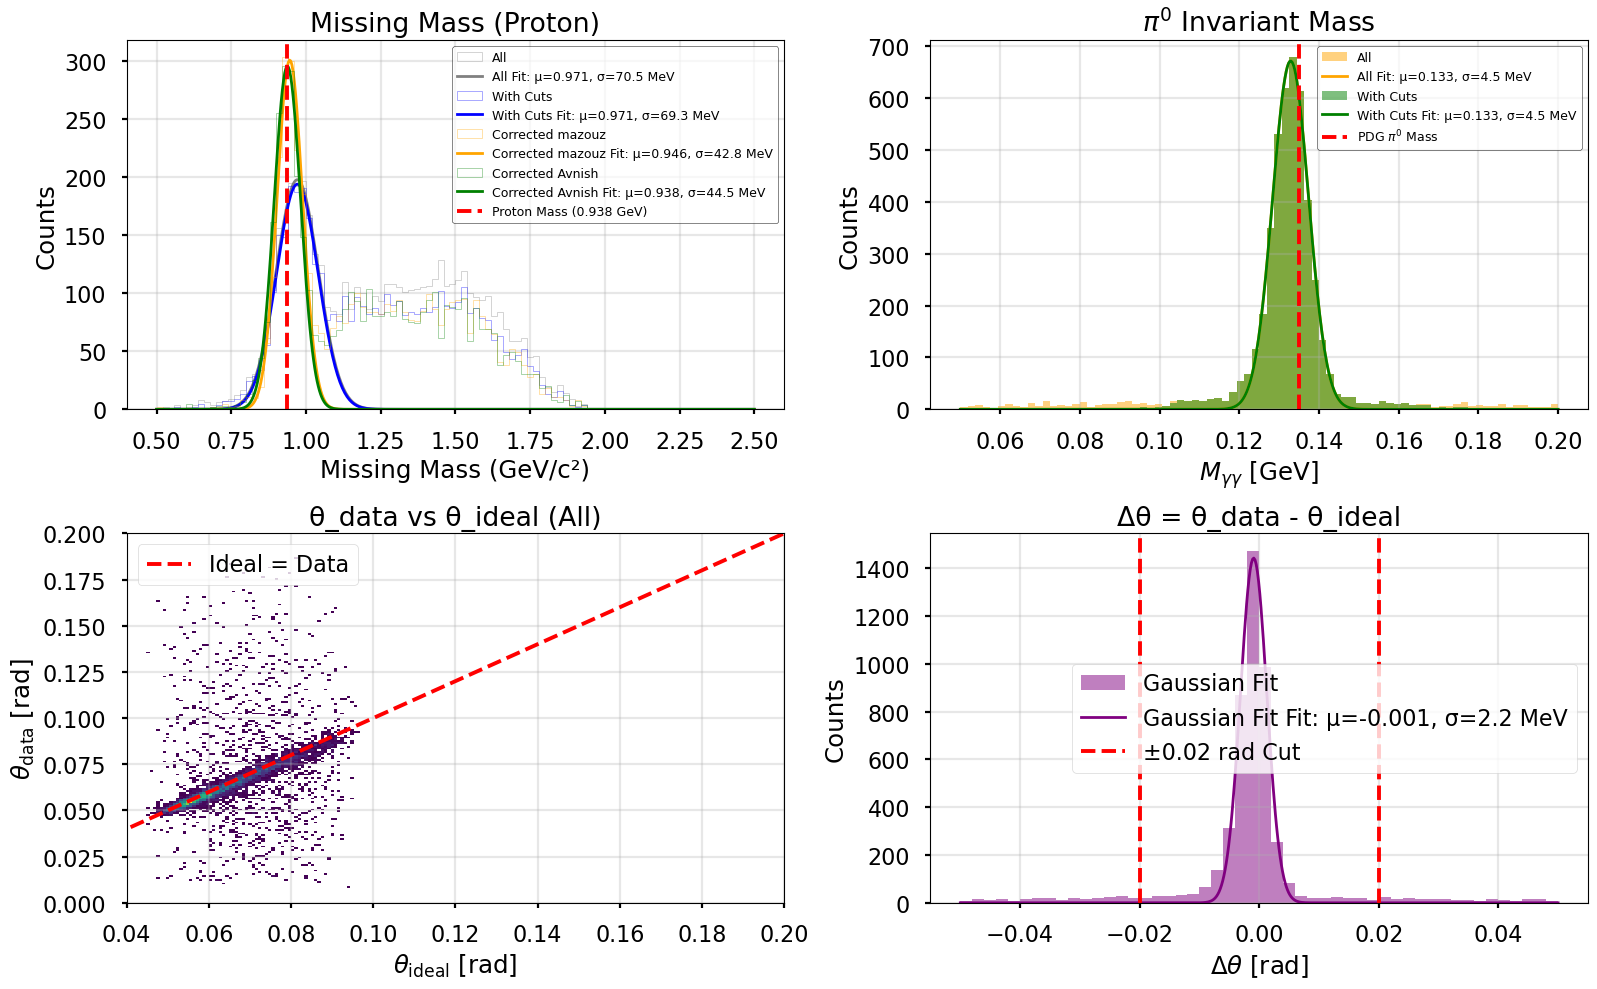

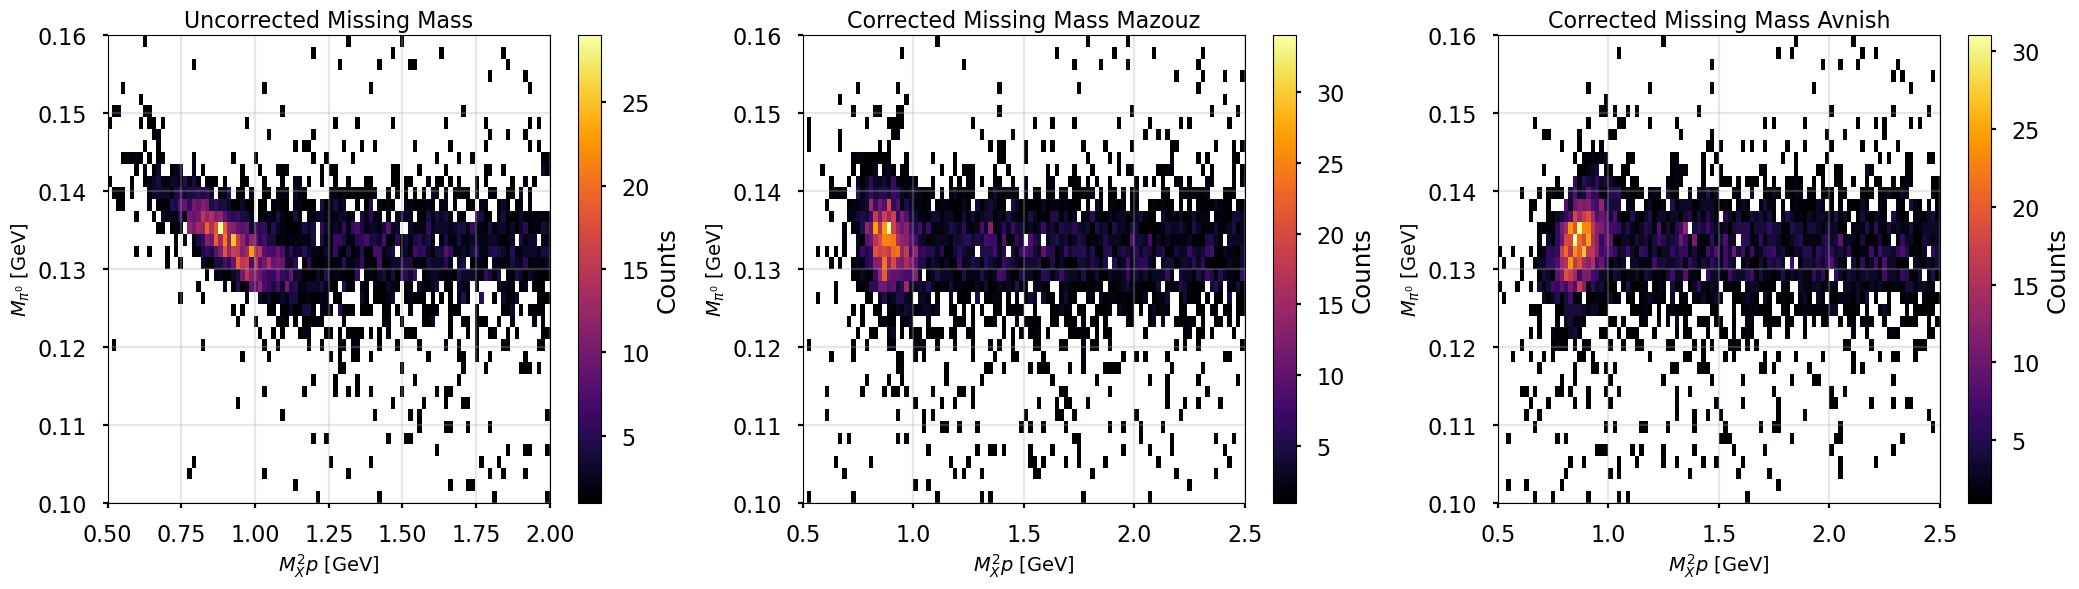

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load data
df = pd.read_csv("exclusive_pi0_proton_data_energycut_1.4.csv")

# Extract relevant columns
miss_pr_all = df.loc[(df["missing_mass_pr_all"] > 0) & (df["invariant_mass_pi0_all"] > 0), "missing_mass_pr_all"].dropna()
miss_pr_cut = df.loc[(df["missing_mass_pr_w_cuts"] > 0) & (df["invariant_mass_pi0_w_cuts"] > 0), "missing_mass_pr_w_cuts"].dropna()
miss_pr_corr_mazouz = df.loc[(df["missing_mass_pr_w_cuts"] > 0) & (df["invariant_mass_pi0_w_cuts"] > 0), "missing_mass_pr_corrected_mazouz"].dropna()
miss_pr_corr_avnish = df.loc[(df["missing_mass_pr_w_cuts"] > 0) & (df["invariant_mass_pi0_w_cuts"] > 0), "missing_mass_pr_corrected_avnish"].dropna()
pi0_all = df.loc[(df["missing_mass_pr_all"] > 0) & (df["invariant_mass_pi0_all"] > 0), "invariant_mass_pi0_all"].dropna()
pi0_cut = df.loc[(df["missing_mass_pr_w_cuts"] > 0) & (df["invariant_mass_pi0_w_cuts"] > 0), "invariant_mass_pi0_w_cuts"].dropna()
theta_data = df.loc[(df["missing_mass_pr_all"] > 0) & (df["invariant_mass_pi0_all"] > 0), "theta_data"]
theta_ideal = df.loc[(df["missing_mass_pr_all"] > 0) & (df["invariant_mass_pi0_all"] > 0), "theta_ideal"]

# print(len(pi0_cut))
# print(len(miss_pr_cut))
# print(len(miss_pr_corr))

# Compute opening angle difference
delta_theta = theta_data - theta_ideal
mask_tight = np.abs(delta_theta) <= 0.02

# Define Gaussian fit function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_and_plot1(ax, data, label, color, bins, range_fit, fit_range=None):
    counts, bins = np.histogram(data, bins=bins, range=range_fit)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    if fit_range:
        fit_mask = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
    else:
        fit_mask = np.ones_like(bin_centers, dtype=bool)

    popt, _ = curve_fit(gaussian, bin_centers[fit_mask], counts[fit_mask], p0=[max(counts), 0.938, 0.01])
    x_fit = np.linspace(range_fit[0], range_fit[1], 500)
    ax.hist(data, bins=bins, range=range_fit, alpha=0.5, color=color, label=label, histtype = 'step')
    ax.plot(x_fit, gaussian(x_fit, *popt), color=color, lw=2,
            label=f"{label} Fit: μ={popt[1]:.3f}, σ={popt[2]*1000:.1f} MeV")
    return ax

def fit_and_plot2(ax, data, label, color, bins, range_fit, fit_range=None):
    counts, bins = np.histogram(data, bins=bins, range=range_fit)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    if fit_range:
        fit_mask = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
    else:
        fit_mask = np.ones_like(bin_centers, dtype=bool)

    popt, _ = curve_fit(gaussian, bin_centers[fit_mask], counts[fit_mask], p0=[max(counts), 0.135, 0.01])
    x_fit = np.linspace(range_fit[0], range_fit[1], 500)
    ax.hist(data, bins=bins, range=range_fit, alpha=0.5, color=color, label=label)
    ax.plot(x_fit, gaussian(x_fit, *popt), color=color, lw=2,
            label=f"{label} Fit: μ={popt[1]:.3f}, σ={popt[2]*1000:.1f} MeV")
    return ax

def fit_and_plot3(ax, data, label, color, bins, range_fit, fit_range=None):
    counts, bins = np.histogram(data, bins=bins, range=range_fit)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    if fit_range:
        fit_mask = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
    else:
        fit_mask = np.ones_like(bin_centers, dtype=bool)

    popt, _ = curve_fit(gaussian, bin_centers[fit_mask], counts[fit_mask], p0=[max(counts), 0.0, 0.01])
    x_fit = np.linspace(range_fit[0], range_fit[1], 500)
    ax.hist(data, bins=bins, range=range_fit, alpha=0.5, color=color, label=label)
    ax.plot(x_fit, gaussian(x_fit, *popt), color=color, lw=2,
            label=f"{label} Fit: μ={popt[1]:.3f}, σ={popt[2]*1000:.1f} MeV")
    return ax
# === Plotting ===

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flatten()

# Proton missing mass
fit_and_plot1(axs[0], miss_pr_all.dropna(), "All", "gray", bins=100, range_fit=(0.5, 2.5), fit_range=(0.8, 1.02))
fit_and_plot1(axs[0], miss_pr_cut.dropna(), "With Cuts", "blue", bins=100, range_fit=(0.5, 2.5), fit_range=(0.8, 1.02))
fit_and_plot1(axs[0], miss_pr_corr_mazouz.dropna(), "Corrected mazouz", "orange", bins=100, range_fit=(0.5, 2.5), fit_range=(0.8, 1.02))
fit_and_plot1(axs[0], miss_pr_corr_avnish.dropna(), "Corrected Avnish", "green", bins=100, range_fit=(0.5, 2.5), fit_range=(0.8, 1.02))

axs[0].axvline(0.938, color='red', linestyle='--', label="Proton Mass (0.938 GeV)")

axs[0].set_xlabel("Missing Mass (GeV/c²)")
axs[0].set_ylabel("Counts")
axs[0].set_title("Missing Mass (Proton)")

# Improved legend style
axs[0].legend(
    loc="upper right",      # put legend in upper right
    fontsize=9,             # smaller text
    frameon=True,           # add background box
    framealpha=0.7,         # transparent box
    facecolor="white",      # white background
    edgecolor="black"       # black border
)

axs[0].grid(True, alpha=0.3)


# π⁰ invariant mass
fit_and_plot2(axs[1], pi0_all.dropna(), "All", "orange", bins=80, range_fit=(0.05, 0.2), fit_range=(0.11, 0.16))
fit_and_plot2(axs[1], pi0_cut.dropna(), "With Cuts", "green", bins=80, range_fit=(0.05, 0.2), fit_range=(0.11, 0.16))
axs[1].axvline(0.13498, color='red', linestyle='--', label=r'PDG $\pi^0$ Mass')
axs[1].set_xlabel(r"$M_{\gamma\gamma}$ [GeV]")
axs[1].set_ylabel("Counts")
axs[1].set_title(r"$\pi^0$ Invariant Mass")
# Improved legend style
axs[1].legend(
    loc="upper right",      # put legend in upper right
    fontsize=9,             # smaller text
    frameon=True,           # add background box
    framealpha=0.7,         # transparent box
    facecolor="white",      # white background
    edgecolor="black"       # black border
)
axs[1].grid(True, alpha=0.3)

# θ_data vs θ_ideal (all)
axs[2].hist2d(theta_ideal, theta_data, bins=200, range=[[0.04, 0.2], [0, 0.20]], cmap='viridis', cmin=1)
axs[2].plot([0, 0.2], [0, 0.2], 'r--', label='Ideal = Data')
axs[2].set_xlabel(r"$\theta_{\mathrm{ideal}}$ [rad]")
axs[2].set_ylabel(r"$\theta_{\mathrm{data}}$ [rad]")
axs[2].set_title("θ_data vs θ_ideal (All)")
axs[2].legend()
axs[2].grid(alpha=0.3)


# plt.figure(figsize=(7, 6))
# plt.hist2d(theta_ideal_nonzero, theta_data_nonzero,
#            bins=200, range=[[0, 0.30], [0, 0.25]], cmap='viridis', cmin=1)
# plt.colorbar(label='Counts')
# plt.plot([0, 0.2], [0, 0.2], 'r--', label='Ideal = Data')
# plt.xlabel(r"$\theta_{\mathrm{ideal}}$ [rad]", fontsize=14)
# plt.ylabel(r"$\theta_{\mathrm{data}}$ [rad]", fontsize=14)
# plt.title(r"$\theta_{\mathrm{data}}$ vs $\theta_{\mathrm{ideal}}$ for $\pi^0$ Candidates", fontsize=16)
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# # plt.savefig("theta_data_vs_ideal.png", dpi=150)
# plt.show()

# Δθ histogram
fit_and_plot3(axs[3], delta_theta, "Gaussian Fit", "purple", bins=50, range_fit=(-0.05, 0.05), fit_range=(-0.02, 0.02))
# axs[3].hist(delta_theta, bins=50, range=(-0.05, 0.05), color='purple', alpha=0.7)
axs[3].axvline(0.02, color='red', linestyle='--', label='±0.02 rad Cut')
axs[3].axvline(-0.02, color='red', linestyle='--')
axs[3].set_xlabel(r"$\Delta\theta$ [rad]")
axs[3].set_ylabel("Counts")
axs[3].set_title("Δθ = θ_data - θ_ideal")
axs[3].legend()
axs[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# # fig, axs = plt.subplots(1, 2, figsize=(16, 10))
# # axs = axs.flatten()

# # Correlation between proton missing mass and pi0 invariant mass
# plt.figure(figsize=(7, 5))
# plt.hist2d(miss_pr_cut**2, pi0_cut,
#            bins=(100, 40), range=[[0.5, 2.0], [0.1, 0.16]],
#            cmap='inferno', cmin=1)
# plt.colorbar(label='Counts')
# plt.xlabel(r"$M_X^2p$ [GeV]", fontsize=14)  # Proton missing mass
# plt.ylabel(r"$M_{\pi^0}$ [GeV]", fontsize=14)  # Pi0 invariant mass
# plt.title(r"$M_{\pi^0}$ vs $M_X^2p$ for Exclusive $\pi^0$ Events", fontsize=16)
# plt.grid(alpha=0.3)
# plt.tight_layout()
# # plt.savefig("pi0_vs_missing_mass.png", dpi=150)
# plt.show()

# plt.figure(figsize=(7, 5))
# plt.hist2d(miss_pr_corr**2, pi0_cut,
#            bins=(100, 40), range=[[0.5, 2.0], [0.1, 0.16]],
#            cmap='inferno', cmin=1)
# plt.colorbar(label='Counts')
# plt.xlabel(r"$M_X^2p$ [GeV]", fontsize=14)  # Proton missing mass
# plt.ylabel(r"$M_{\pi^0}$ [GeV]", fontsize=14)  # Pi0 invariant mass
# plt.title(r"$M_{\pi^0}$ vs $M_X^2p$ for Exclusive $\pi^0$ Events", fontsize=16)
# plt.grid(alpha=0.3)
# plt.tight_layout()
# # plt.savefig("pi0_vs_missing_mass.png", dpi=150)
# plt.show()

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
axs = axs.flatten()

# 1 — Uncorrected MX^2p vs M_pi0
h1 = axs[0].hist2d(miss_pr_cut**2, pi0_cut,
                   bins=(100, 40), range=[[0.5, 2.0], [0.1, 0.16]],
                   cmap='inferno', cmin=1)
fig.colorbar(h1[3], ax=axs[0], label='Counts')

# Overlay contour lines
# Xcenters = 0.5 * (h1[1][1:] + h1[1][:-1])
# Ycenters = 0.5 * (h1[2][1:] + h1[2][:-1])
# X, Y = np.meshgrid(Xcenters, Ycenters)
# axs[0].contour(X, Y, h1[0].T, colors='white', linewidths=0.8, levels=6)

axs[0].set_xlabel(r"$M_X^2p$ [GeV]", fontsize=14)
axs[0].set_ylabel(r"$M_{\pi^0}$ [GeV]", fontsize=14)
axs[0].set_title("Uncorrected Missing Mass", fontsize=16)
axs[0].grid(alpha=0.3)

# 2 — Corrected mazouz MX^2p vs M_pi0
h2 = axs[1].hist2d(miss_pr_corr_mazouz**2, pi0_cut,
                   bins=(100, 40), range=[[0.5, 2.5], [0.1, 0.16]],
                   cmap='inferno', cmin=1)
fig.colorbar(h2[3], ax=axs[1], label='Counts')

# # Overlay contour lines
# Xcenters2 = 0.5 * (h2[1][1:] + h2[1][:-1])
# Ycenters2 = 0.5 * (h2[2][1:] + h2[2][:-1])
# X2, Y2 = np.meshgrid(Xcenters2, Ycenters2)
# axs[1].contour(X2, Y2, h2[0].T, colors='white', linewidths=0.8, levels=6)

axs[1].set_xlabel(r"$M_X^2p$ [GeV]", fontsize=14)
axs[1].set_ylabel(r"$M_{\pi^0}$ [GeV]", fontsize=14)
axs[1].set_title("Corrected Missing Mass Mazouz", fontsize=16)
axs[1].grid(alpha=0.3)


# # 3 — Difference: Corrected - Uncorrected
# mass_diff = miss_pr_corr_mazouz - miss_pr_cut
# axs[2].hist(mass_diff, bins=100, range=(-0.2, 0.2), color='steelblue', alpha=0.7)
# axs[2].set_xlabel(r"$\Delta M_p = M_p^{corr} - M_p^{uncorr}$ [GeV]", fontsize=14)
# axs[2].set_ylabel("Counts", fontsize=14)
# axs[2].set_title("Mass Difference Distribution", fontsize=16)
# axs[2].grid(alpha=0.3)

# 2 — Corrected Avnishy MX^2p vs M_pi0
h3 = axs[2].hist2d(miss_pr_corr_avnish**2, pi0_cut,
                   bins=(100, 40), range=[[0.5, 2.5], [0.1, 0.16]],
                   cmap='inferno', cmin=1)
fig.colorbar(h3[3], ax=axs[2], label='Counts')

# Xcenters3 = 0.5 * (h3[1][1:] + h3[1][:-1])
# Ycenters3 = 0.5 * (h3[2][1:] + h3[2][:-1])
# X3, Y3 = np.meshgrid(Xcenters3, Ycenters3)
# axs[2].contour(X3, Y3, h3[0].T, colors='white', linewidths=0.8, levels=6)

axs[2].set_xlabel(r"$M_X^2p$ [GeV]", fontsize=14)
axs[2].set_ylabel(r"$M_{\pi^0}$ [GeV]", fontsize=14)
axs[2].set_title("Corrected Missing Mass Avnish", fontsize=16)
axs[2].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# # Correlation between proton missing mass and pi0 invariant mass
# plt.figure(figsize=(7, 5))
# plt.hist2d(miss_pr_corr_avnish**2, pi0_cut,
#            bins=(100, 40), range=[[0.5, 2.0], [0.1, 0.16]],
#            cmap='inferno', cmin=1)
# plt.colorbar(label='Counts')
# plt.xlabel(r"$M_X^2p$ [GeV]", fontsize=14)  # Proton missing mass
# plt.ylabel(r"$M_{\pi^0}$ [GeV]", fontsize=14)  # Pi0 invariant mass
# plt.title(r"$M_{\pi^0}$ vs $M_X^2p$ for Exclusive $\pi^0$ Events", fontsize=16)
# plt.grid(alpha=0.3)
# plt.tight_layout()
# # plt.savefig("pi0_vs_missing_mass.png", dpi=150)
# plt.show()

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr, spearmanr
import glob
import os
import re

# === Gaussian fit function ===
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_and_plot1(ax, data, label, color, bins, range_fit, fit_range=None):
    counts, bins = np.histogram(data, bins=bins, range=range_fit)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    if fit_range:
        fit_mask = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
    else:
        fit_mask = np.ones_like(bin_centers, dtype=bool)

    popt, _ = curve_fit(gaussian, bin_centers[fit_mask], counts[fit_mask],
                        p0=[max(counts), 0.938, 0.01])
    x_fit = np.linspace(range_fit[0], range_fit[1], 500)
    ax.hist(data, bins=bins, range=range_fit, alpha=0.5, color=color,
            label=label, histtype='step')
    ax.plot(x_fit, gaussian(x_fit, *popt), color=color, lw=2,
            label=f"{label} Fit: μ={popt[1]:.3f}, σ={popt[2]*1000:.1f} MeV")
    return ax

# === Process each file ===
file_list = sorted(glob.glob("exclusive_pi0_proton_data_energycut_*.csv"))

for file_path in file_list:
    # Extract energy cut from filename, e.g. 'exclusive_pi0_proton_data_energycut_1.4.csv'
    match = re.search(r"energycut_([0-9.]+)", file_path)
    energy_cut = match.group(1) if match else "unknown"
    # energy_cut = float(match.group(1)) if match else None

    print(f"Processing {file_path}...")
    df = pd.read_csv(file_path)

    # Extract relevant columns
    miss_pr_all = df.loc[(df["missing_mass_pr_all"] > 0) & 
                         (df["invariant_mass_pi0_all"] > 0), "missing_mass_pr_all"].dropna()
    miss_pr_cut = df.loc[(df["missing_mass_pr_w_cuts"] > 0) &
                         (df["invariant_mass_pi0_w_cuts"] > 0), "missing_mass_pr_w_cuts"].dropna()
    miss_pr_corr_mazouz = df.loc[(df["missing_mass_pr_w_cuts"] > 0) &
                                 (df["invariant_mass_pi0_w_cuts"] > 0), "missing_mass_pr_corrected_mazouz"].dropna()
    miss_pr_corr_avnish = df.loc[(df["missing_mass_pr_w_cuts"] > 0) &
                                 (df["invariant_mass_pi0_w_cuts"] > 0), "missing_mass_pr_corrected_avnish"].dropna()
    pi0_all = df.loc[(df["missing_mass_pr_all"] > 0) &
                     (df["invariant_mass_pi0_all"] > 0), "invariant_mass_pi0_all"].dropna()
    pi0_cut = df.loc[(df["missing_mass_pr_w_cuts"] > 0) &
                     (df["invariant_mass_pi0_w_cuts"] > 0), "invariant_mass_pi0_w_cuts"].dropna()
    # print(len(miss_pr_corr_mazouz))
    # print(len(miss_pr_corr_avnish))
    # print(len(pi0_cut))
    # === correlation calculations ===
    pearson_maz, _ = pearsonr(miss_pr_corr_mazouz**2, pi0_cut)
    spearman_maz, _ = spearmanr(miss_pr_corr_mazouz**2, pi0_cut)

    pearson_avn, _ = pearsonr(miss_pr_corr_avnish**2, pi0_cut)
    spearman_avn, _ = spearmanr(miss_pr_corr_avnish**2, pi0_cut)

    print(f"Correlation results for {file_path}:")
    print(f"  mazouz  : Pearson = {pearson_maz:.4f}, Spearman = {spearman_maz:.4f}")
    print(f"  Avnish  : Pearson = {pearson_avn:.4f}, Spearman = {spearman_avn:.4f}")

    # === Plotting ===
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs = axs.flatten()

    # Proton missing mass
    fit_and_plot1(axs[0], miss_pr_all, "All", "gray", bins=100, range_fit=(0.5, 2.5), fit_range=(0.8, 1.02))
    fit_and_plot1(axs[0], miss_pr_cut, "With Cuts", "blue", bins=100, range_fit=(0.5, 2.5), fit_range=(0.8, 1.02))
    fit_and_plot1(axs[0], miss_pr_corr_mazouz, "Corrected mazouz", "orange", bins=100, range_fit=(0.5, 2.5), fit_range=(0.8, 1.02))
    fit_and_plot1(axs[0], miss_pr_corr_avnish, "Corrected Avnish", "green", bins=100, range_fit=(0.5, 2.5), fit_range=(0.8, 1.02))

    axs[0].axvline(0.938, color='red', linestyle='--', label="Proton Mass (0.938 GeV)")
    axs[0].set_xlabel("Missing Mass (GeV/c²)")
    axs[0].set_ylabel("Counts")
    axs[0].set_title("Missing Mass (Proton)")
    axs[0].legend(loc="upper right", fontsize=9, frameon=True, framealpha=0.7,
                  facecolor="white", edgecolor="black")
    axs[0].grid(True, alpha=0.3)

    # 1 — Uncorrected MX^2p vs M_pi0
    h1 = axs[1].hist2d(miss_pr_cut**2, pi0_cut,
                       bins=(100, 40), range=[[0.5, 2.0], [0.1, 0.16]],
                       cmap='inferno', cmin=1)
    fig.colorbar(h1[3], ax=axs[1], label='Counts')
    axs[1].set_xlabel(r"$M_X^2p$ [GeV]", fontsize=14)
    axs[1].set_ylabel(r"$M_{\pi^0}$ [GeV]", fontsize=14)
    axs[1].set_title("Uncorrected Missing Mass", fontsize=16)
    axs[1].grid(alpha=0.3)

    # 2 — Corrected mazouz MX^2p vs M_pi0
    h2 = axs[2].hist2d(miss_pr_corr_mazouz**2, pi0_cut,
                       bins=(100, 40), range=[[0.5, 2.5], [0.1, 0.16]],
                       cmap='inferno', cmin=1)
    fig.colorbar(h2[3], ax=axs[2], label='Counts')
    axs[2].set_xlabel(r"$M_X^2p$ [GeV]", fontsize=14)
    axs[2].set_ylabel(r"$M_{\pi^0}$ [GeV]", fontsize=14)
    axs[2].set_title("Corrected Missing Mass Mazouz", fontsize=16)
    axs[2].grid(alpha=0.3)
    # Place correlation text on plot
    # axs[2].text(0.52, 0.155,
    #             f"Pearson: {pearson_maz:.3f}\nSpearman: {spearman_maz:.3f}",
    #             color="white", fontsize=10,
    #             ha="left", va="top",
    #             bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

    # 3 — Corrected Avnish MX^2p vs M_pi0
    h3 = axs[3].hist2d(miss_pr_corr_avnish**2, pi0_cut,
                       bins=(100, 40), range=[[0.5, 2.5], [0.1, 0.16]],
                       cmap='inferno', cmin=1)
    fig.colorbar(h3[3], ax=axs[3], label='Counts')
    axs[3].set_xlabel(r"$M_X^2p$ [GeV]", fontsize=14)
    axs[3].set_ylabel(r"$M_{\pi^0}$ [GeV]", fontsize=14)
    axs[3].set_title("Corrected Missing Mass Avnish", fontsize=16)
    axs[3].grid(alpha=0.3)
    # Place correlation text on plot
    # axs[3].text(0.52, 0.155,
    #             f"Pearson: {pearson_avn:.3f}\nSpearman: {spearman_avn:.3f}",
    #             color="white", fontsize=10,
    #             ha="left", va="top",
    #             bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    
    # Add energy cut annotation on the figure (relative coordinates)
    fig.text(0.02, 0.98, f"Energy Cut: {energy_cut} GeV", fontsize=14, color="black",
             ha='left', va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    plt.tight_layout()
    # Save figure per file
    out_name = os.path.splitext(os.path.basename(file_path))[0] + "_plots.png"
    out_path = os.path.join("plots_miss_mass", out_name)
    # plt.show()
    plt.savefig(out_path, dpi=300)
    plt.close()

print("Processing complete. Plots saved for all files.")


Processing exclusive_pi0_proton_data_energycut_0.5.csv...
Correlation results for exclusive_pi0_proton_data_energycut_0.5.csv:
  mazouz  : Pearson = -0.0187, Spearman = -0.1100
  Avnish  : Pearson = 0.0603, Spearman = -0.0340
Processing exclusive_pi0_proton_data_energycut_0.6.csv...
Correlation results for exclusive_pi0_proton_data_energycut_0.6.csv:
  mazouz  : Pearson = -0.0146, Spearman = -0.1101
  Avnish  : Pearson = 0.0627, Spearman = -0.0345
Processing exclusive_pi0_proton_data_energycut_0.7.csv...
Correlation results for exclusive_pi0_proton_data_energycut_0.7.csv:
  mazouz  : Pearson = -0.0095, Spearman = -0.1092
  Avnish  : Pearson = 0.0663, Spearman = -0.0333
Processing exclusive_pi0_proton_data_energycut_0.8.csv...
Correlation results for exclusive_pi0_proton_data_energycut_0.8.csv:
  mazouz  : Pearson = 0.0005, Spearman = -0.1058
  Avnish  : Pearson = 0.0764, Spearman = -0.0282
Processing exclusive_pi0_proton_data_energycut_0.9.csv...
Correlation results for exclusive_pi0_p

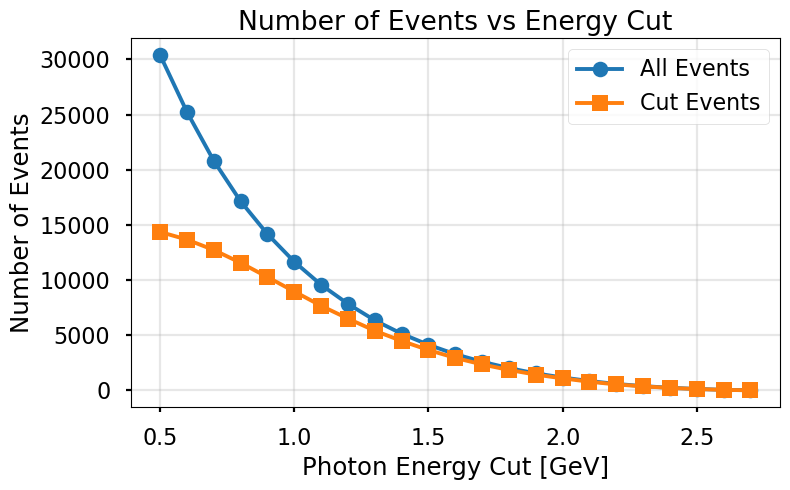

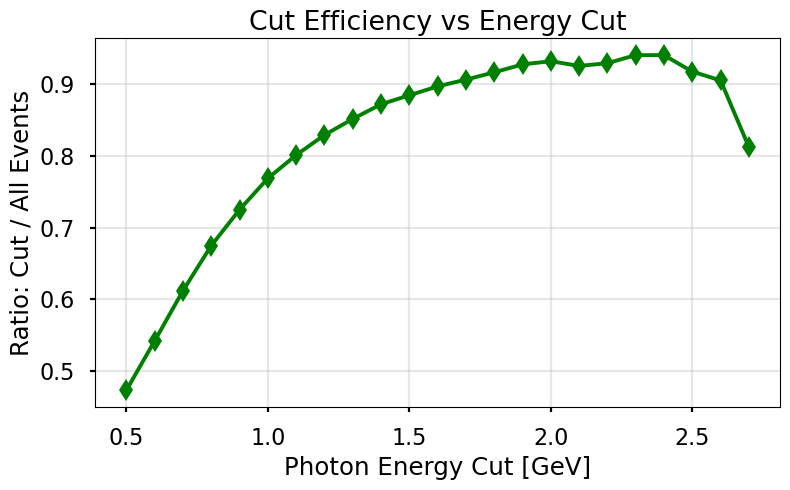

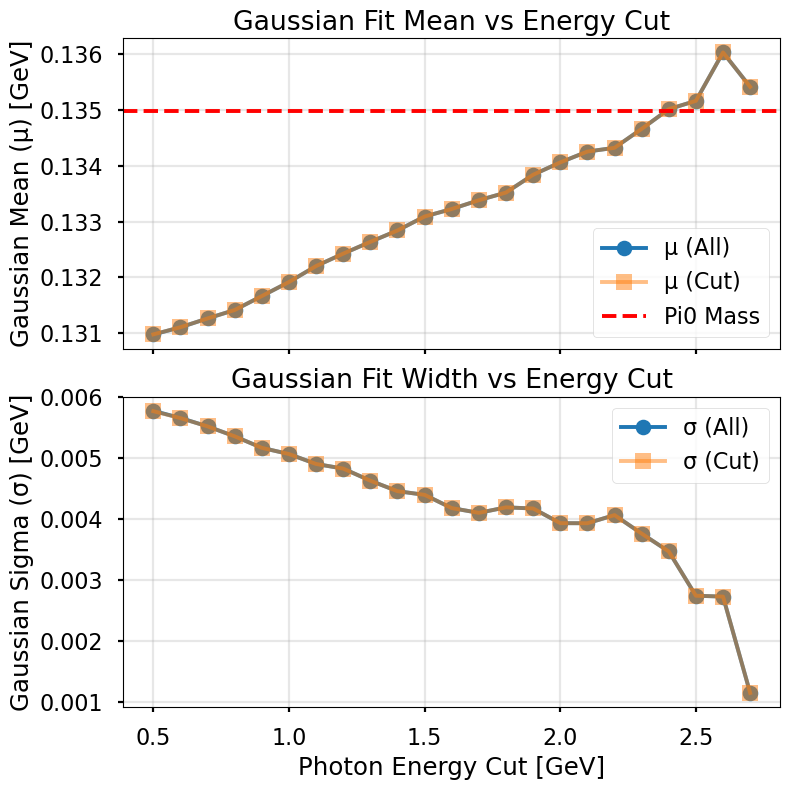

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.optimize import curve_fit

# === Gaussian Fit Function ===
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# === Load all files ===
file_list = sorted(glob.glob("exclusive_pi0_proton_data_energycut_*.csv"))

energy_cuts = []
n_all_events = []
n_cut_events = []
ratios = []
mu_all_list = []
sigma_all_list = []
mu_cut_list = []
sigma_cut_list = []

# bins = np.linspace(0.5, 2.5, 100)
# bin_centers = (bins[:-1] + bins[1:]) / 2
# fit_mask = (bin_centers > 0.8) & (bin_centers < 1.02)

bins = np.linspace(0.05, 0.2, 100)
bin_centers = (bins[:-1] + bins[1:]) / 2
fit_mask = (bin_centers > 0.12) & (bin_centers < 0.14)

# === Loop through all files ===
for file in file_list:
    # Extract energy value from filename
    energy = float(file.split("_")[-1].replace(".csv", ""))
    energy_cuts.append(energy)

    df = pd.read_csv(file)

    # Event counts
    # all_events = df[df["missing_mass_pr_all"]>0].dropna()
    # cut_events = df[df["missing_mass_pr_w_cuts"]>0].dropna()

    all_pi0_events = df.loc[(df["missing_mass_pr_all"] > 0) & (df["invariant_mass_pi0_all"] > 0), "invariant_mass_pi0_all"].dropna()
    cut_pi0_events = df.loc[(df["missing_mass_pr_w_cuts"] > 0) & (df["invariant_mass_pi0_w_cuts"] > 0), "invariant_mass_pi0_w_cuts"].dropna()

    all_pr_events = df.loc[(df["missing_mass_pr_all"] > 0) & (df["invariant_mass_pi0_all"] > 0), "missing_mass_pr_all"].dropna()
    cut_pr_events = df.loc[(df["missing_mass_pr_w_cuts"] > 0) & (df["invariant_mass_pi0_w_cuts"] > 0), "missing_mass_pr_w_cuts"].dropna()

    n_all = len(all_pi0_events)
    n_cut = len(cut_pi0_events)

    # print('n_all: ', n_all)
    # print('n_cut: ', n_cut)

    n_all_events.append(n_all)
    n_cut_events.append(n_cut)
    ratios.append(n_cut / n_all if n_all > 0 else np.nan)

    # Gaussian fits for invariant mass
    hist_all, _ = np.histogram(all_pi0_events, bins=bins)
    hist_cut, _ = np.histogram(cut_pi0_events, bins=bins)

    try:
        popt_all, _ = curve_fit(gaussian, bin_centers[fit_mask], hist_all[fit_mask],
                                p0=[max(hist_all), 0.135, 0.002])
        mu_all_list.append(popt_all[1])
        sigma_all_list.append(popt_all[2])
    except:
        mu_all_list.append(np.nan)
        sigma_all_list.append(np.nan)

    try:
        popt_cut, _ = curve_fit(gaussian, bin_centers[fit_mask], hist_cut[fit_mask],
                                p0=[max(hist_cut), 0.135, 0.002])
        mu_cut_list.append(popt_cut[1])
        sigma_cut_list.append(popt_cut[2])
    except:
        mu_cut_list.append(np.nan)
        sigma_cut_list.append(np.nan)

    # # Gaussian fits for invariant mass
    # hist_all, _ = np.histogram(all_pi0_events, bins=bins)
    # hist_cut, _ = np.histogram(cut_pi0_events, bins=bins)

    # try:
    #     popt_all, _ = curve_fit(gaussian, bin_centers[fit_mask], hist_all[fit_mask],
    #                             p0=[max(hist_all), 0.135, 0.002])
    #     mu_all_list.append(popt_all[1])
    #     sigma_all_list.append(popt_all[2])
    # except:
    #     mu_all_list.append(np.nan)
    #     sigma_all_list.append(np.nan)

    # try:
    #     popt_cut, _ = curve_fit(gaussian, bin_centers[fit_mask], hist_cut[fit_mask],
    #                             p0=[max(hist_cut), 0.135, 0.002])
    #     mu_cut_list.append(popt_cut[1])
    #     sigma_cut_list.append(popt_cut[2])
    # except:
    #     mu_cut_list.append(np.nan)
    #     sigma_cut_list.append(np.nan)

# === Sort by energy ===
energy_cuts = np.array(energy_cuts)
sort_idx = np.argsort(energy_cuts)

energy_cuts = energy_cuts[sort_idx]
n_all_events = np.array(n_all_events)[sort_idx]
n_cut_events = np.array(n_cut_events)[sort_idx]
ratios = np.array(ratios)[sort_idx]
mu_all_list = np.array(mu_all_list)[sort_idx]
sigma_all_list = np.array(sigma_all_list)[sort_idx]
mu_cut_list = np.array(mu_cut_list)[sort_idx]
sigma_cut_list = np.array(sigma_cut_list)[sort_idx]

# === Plot: Number of Events vs Energy Cut ===
plt.figure(figsize=(8, 5))
plt.plot(energy_cuts, n_all_events, 'o-', label='All Events')
plt.plot(energy_cuts, n_cut_events, 's-', label='Cut Events')
plt.xlabel("Photon Energy Cut [GeV]")
plt.ylabel("Number of Events")
plt.title("Number of Events vs Energy Cut")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === Plot: Ratio of Cut/All Events ===
plt.figure(figsize=(8, 5))
plt.plot(energy_cuts, ratios, 'd-', color='green')
plt.xlabel("Photon Energy Cut [GeV]")
plt.ylabel("Ratio: Cut / All Events")
plt.title("Cut Efficiency vs Energy Cut")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === Plot: Gaussian μ and σ vs Energy Cut ===
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

axs[0].plot(energy_cuts, mu_all_list, 'o-', label='μ (All)')
axs[0].plot(energy_cuts, mu_cut_list, 's-', label='μ (Cut)', alpha = 0.5)
# axs[0].axhline(0.938, color='red', linestyle='--', label='Proton Mass')
axs[0].axhline(0.13498, color='red', linestyle='--', label='Pi0 Mass')
axs[0].set_ylabel("Gaussian Mean (μ) [GeV]")
axs[0].set_title("Gaussian Fit Mean vs Energy Cut")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(energy_cuts, sigma_all_list, 'o-', label='σ (All)')
axs[1].plot(energy_cuts, sigma_cut_list, 's-', label='σ (Cut)', alpha = 0.5)
axs[1].set_xlabel("Photon Energy Cut [GeV]")
axs[1].set_ylabel("Gaussian Sigma (σ) [GeV]")
axs[1].set_title("Gaussian Fit Width vs Energy Cut")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()